<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_12/DNN_assignment_12_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics

In [2]:

import os
import random
import torch
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassAccuracy
import torch.optim as optim
from tqdm import tqdm
import time

#Dataset Processing

In [3]:
# Load dataset
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
val_ratio = 0.1
generator = torch.Generator().manual_seed(seed)
use_reduced_data = True

transform = transforms.Compose([
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-30, 30)),
    # transforms.ColorJitter(),
    transforms.RandAugment(num_ops=2, magnitude=7),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformTest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

CIFAR10Dataset = torchvision.datasets.CIFAR10(root='.', download=True)
full_train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=None)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transformTest)

if use_reduced_data:
    total_reduced_size = 10000
    selected_indices = torch.randperm(len(full_train_dataset), generator=generator)[:total_reduced_size]
else:
    selected_indices = torch.arange(len(full_train_dataset))

val_size = int(len(selected_indices) * val_ratio)
train_size = len(selected_indices) - val_size
train_indices, val_indices = random_split(selected_indices, [train_size, val_size], generator=generator)


train_dataset = Subset(
    torchvision.datasets.CIFAR10(root='.', train=True, download=False, transform=transform),
    train_indices.indices
)

val_dataset = Subset(
    torchvision.datasets.CIFAR10(root='.', train=True, download=False, transform=transformTest),
    val_indices.indices
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())

100%|██████████| 170M/170M [00:04<00:00, 37.4MB/s]


#Pretrained model

In [4]:

import torch.nn as nn
from torchvision.models import resnet50, mobilenet_v3_large

def get_resnet50(num_classes=10):
    model = resnet50(pretrained=True)

    # Adjust first conv and maxpool for CIFAR-10 input size
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last half: layer3, layer4, and fc
    for name, param in model.named_parameters():
        if "layer3" in name or "layer4" in name or "fc" in name:
            param.requires_grad = True

    # Replace final classification layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


#Small CNN model

In [5]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Changed input channels to 3 for RGB
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Calculate the flattened size dynamically
        # Input size: 32x32
        # After conv1 and pool: (32/2) x (32/2) = 16x16, with 16 channels -> 16*16*16
        # After conv2 and pool: (16/2) x (16/2) = 8x8, with 32 channels -> 8*8*32 = 2048
        self.fc1 = nn.Linear(32 * 8 * 8, 128) # Corrected input features to 32 * 8 * 8
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 3x32x32 -> 16x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16x16 -> 32x8x8
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#training funtion

In [6]:
import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, device, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= val_total
        val_acc = 100 * val_correct / val_total

        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    return model, history


#ploating funtion

In [16]:
def validation(model, loader, device, show_metrics=True):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss() # Define criterion for validation loss

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels) # Calculate validation loss
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    acc = correct / total

    if show_metrics:
        print(f"Validation Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    return acc, loss

In [19]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    if isinstance(history, dict):
        epochs = range(1, len(history['train_loss']) + 1)
        train_loss = history['train_loss']
        val_loss = history['val_loss']
        train_acc = history['train_acc']
        val_acc = history['val_acc']
    elif isinstance(history, list):
        epochs = range(1, len(history) + 1)
        train_acc = [h[0] for h in history]
        train_loss = [h[1] for h in history]
        val_acc = [h[2] for h in history]
        val_loss = [h[3] for h in history]
    else:
        print("Unsupported history format.")
        return

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [acc * 100 for acc in train_acc], label='Train Accuracy') # Convert to percentage
    plt.plot(epochs, [acc * 100 for acc in val_acc], label='Validation Accuracy') # Convert to percentage
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#Model Training

In [8]:
model = get_resnet50()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model, history_resNet50 = train(model, train_loader, val_loader, device, epochs=30, lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


Epoch [1/30] Train Loss: 1.7753, Acc: 37.07% | Val Loss: 1.4372, Acc: 48.50%
Epoch [2/30] Train Loss: 1.4382, Acc: 48.21% | Val Loss: 1.2884, Acc: 56.00%
Epoch [3/30] Train Loss: 1.2919, Acc: 53.98% | Val Loss: 1.0633, Acc: 63.10%
Epoch [4/30] Train Loss: 1.2029, Acc: 58.29% | Val Loss: 1.0287, Acc: 63.10%
Epoch [5/30] Train Loss: 1.1098, Acc: 61.17% | Val Loss: 0.9640, Acc: 65.80%
Epoch [6/30] Train Loss: 1.0589, Acc: 63.33% | Val Loss: 0.9041, Acc: 69.90%
Epoch [7/30] Train Loss: 1.0191, Acc: 64.36% | Val Loss: 1.0183, Acc: 67.30%
Epoch [8/30] Train Loss: 0.9676, Acc: 66.42% | Val Loss: 0.8236, Acc: 69.50%
Epoch [9/30] Train Loss: 0.9525, Acc: 67.41% | Val Loss: 0.8993, Acc: 68.50%
Epoch [10/30] Train Loss: 0.8918, Acc: 68.37% | Val Loss: 0.7708, Acc: 73.50%
Epoch [11/30] Train Loss: 0.8588, Acc: 70.53% | Val Loss: 0.7911, Acc: 71.90%
Epoch [12/30] Train Loss: 0.8320, Acc: 70.78% | Val Loss: 0.7209, Acc: 75.40%
Epoch [13/30] Train Loss: 0.8085, Acc: 71.98% | Val Loss: 0.9028, Acc: 70

In [9]:
model2 = SmallCNN(num_classes=10)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model2, history_smallCNN = train(model2, train_loader, val_loader, device, epochs=30, lr=0.001)


Epoch [1/30] Train Loss: 2.0165, Acc: 27.12% | Val Loss: 1.6743, Acc: 40.40%
Epoch [2/30] Train Loss: 1.7804, Acc: 36.32% | Val Loss: 1.5468, Acc: 45.80%
Epoch [3/30] Train Loss: 1.6726, Acc: 39.79% | Val Loss: 1.4521, Acc: 48.40%
Epoch [4/30] Train Loss: 1.6205, Acc: 41.72% | Val Loss: 1.4322, Acc: 50.10%
Epoch [5/30] Train Loss: 1.5788, Acc: 43.23% | Val Loss: 1.3584, Acc: 52.50%
Epoch [6/30] Train Loss: 1.5273, Acc: 45.37% | Val Loss: 1.3539, Acc: 51.90%
Epoch [7/30] Train Loss: 1.4824, Acc: 46.97% | Val Loss: 1.2971, Acc: 53.70%
Epoch [8/30] Train Loss: 1.4582, Acc: 47.71% | Val Loss: 1.2893, Acc: 53.80%
Epoch [9/30] Train Loss: 1.4313, Acc: 48.78% | Val Loss: 1.2427, Acc: 55.70%
Epoch [10/30] Train Loss: 1.4233, Acc: 49.23% | Val Loss: 1.2431, Acc: 58.90%
Epoch [11/30] Train Loss: 1.3925, Acc: 50.11% | Val Loss: 1.2085, Acc: 57.70%
Epoch [12/30] Train Loss: 1.3783, Acc: 51.02% | Val Loss: 1.1733, Acc: 59.30%
Epoch [13/30] Train Loss: 1.3665, Acc: 51.67% | Val Loss: 1.1802, Acc: 58

#knowledge distilation

In [11]:
def train_knowledge_distillation(teacher, student, train_loader, val_loader, epochs, learning_rate, T, alpha, device):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(student.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    results = []

    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()
        for inputs, labels in (train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                teacher_logits = teacher(inputs)
            student_logits = student(inputs)

            label_loss = criterion(student_logits, labels)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_targets_loss = F.kl_div(soft_prob, soft_targets, reduction='batchmean') * (T ** 2)
            loss = alpha * soft_targets_loss + (1 - alpha) * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(student_logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        val_acc, val_loss = validation(student, val_loader, device, show_metrics=False)
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}({time.time() - start_time:.2f}s) - accuracy: {train_acc:.4f}  - loss: {train_loss:.4f}  - val_accuracy: {val_acc:.4f}  - val_loss: {val_loss:.4f}")
        results.append([train_acc, train_loss, val_acc, val_loss])
    return results

In [28]:
T, alpha = 4, 0.8
epochs = 30 # Define epochs
# learning_rate = 0.01 # Define learning_rate
history_kd = train_knowledge_distillation(trained_model, model2, train_loader, val_loader, 30, learning_rate, T=T, alpha=alpha, device=device)
# validation(student, test_loader, device) # Commenting out this line as 'student' is not defined and there is no validation function defined.

Epoch 1/30(10.79s) - accuracy: 0.4826  - loss: 2.8811  - val_accuracy: 0.5650  - val_loss: 1.3861
Epoch 2/30(10.70s) - accuracy: 0.4826  - loss: 2.8804  - val_accuracy: 0.5710  - val_loss: 1.3739
Epoch 3/30(10.88s) - accuracy: 0.4817  - loss: 2.8985  - val_accuracy: 0.5600  - val_loss: 1.5146
Epoch 4/30(10.83s) - accuracy: 0.4839  - loss: 2.8677  - val_accuracy: 0.5370  - val_loss: 1.4826
Epoch 5/30(10.31s) - accuracy: 0.4859  - loss: 2.8072  - val_accuracy: 0.5680  - val_loss: 1.4988
Epoch 6/30(10.54s) - accuracy: 0.4961  - loss: 2.7611  - val_accuracy: 0.5390  - val_loss: 1.6262
Epoch 7/30(10.65s) - accuracy: 0.5023  - loss: 2.7013  - val_accuracy: 0.5790  - val_loss: 1.3552
Epoch 8/30(10.58s) - accuracy: 0.5094  - loss: 2.7082  - val_accuracy: 0.5760  - val_loss: 1.4435
Epoch 9/30(10.75s) - accuracy: 0.5079  - loss: 2.6572  - val_accuracy: 0.5500  - val_loss: 1.5505
Epoch 10/30(10.75s) - accuracy: 0.5211  - loss: 2.6182  - val_accuracy: 0.5940  - val_loss: 1.3806
Epoch 11/30(9.88s) 

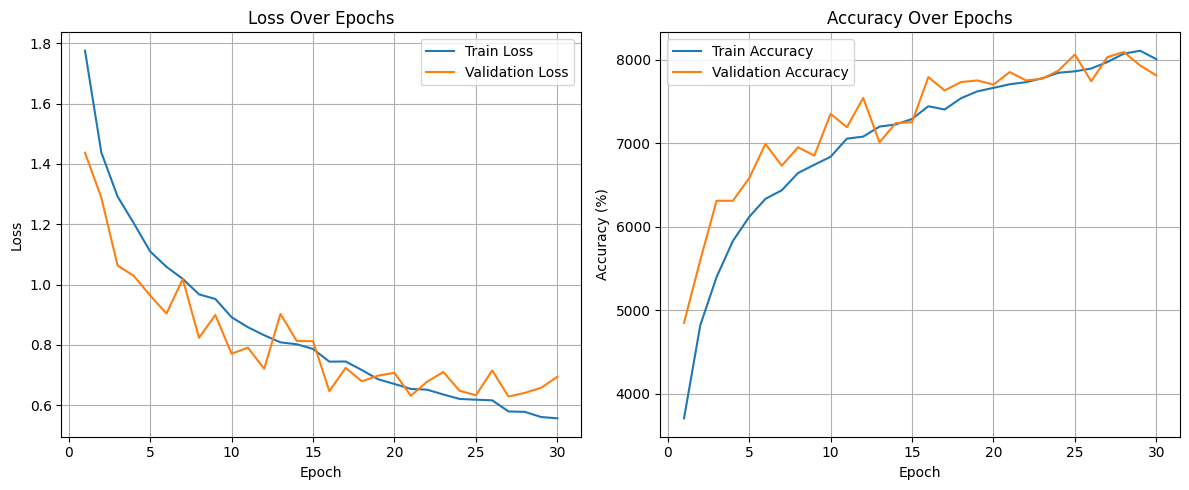

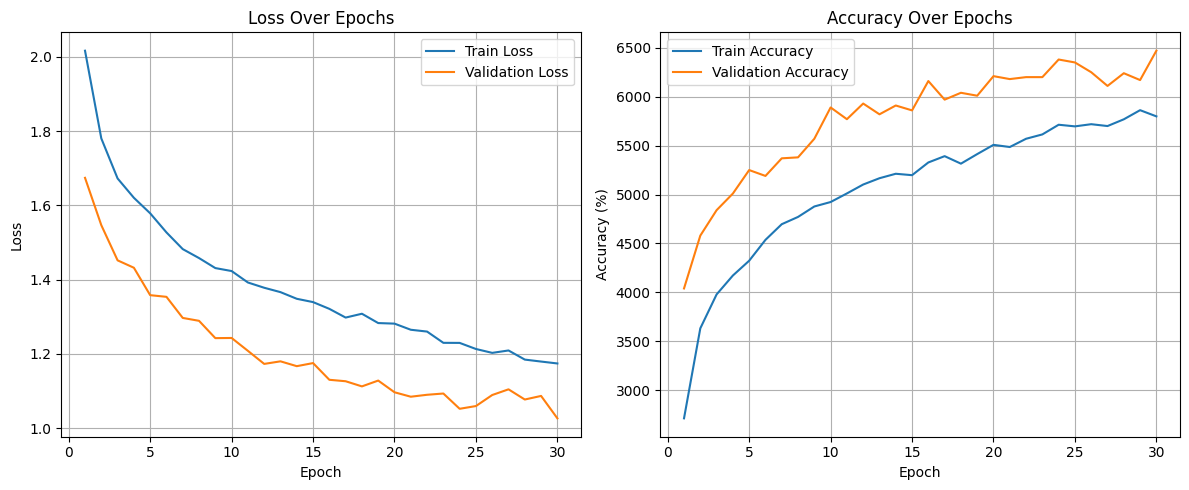

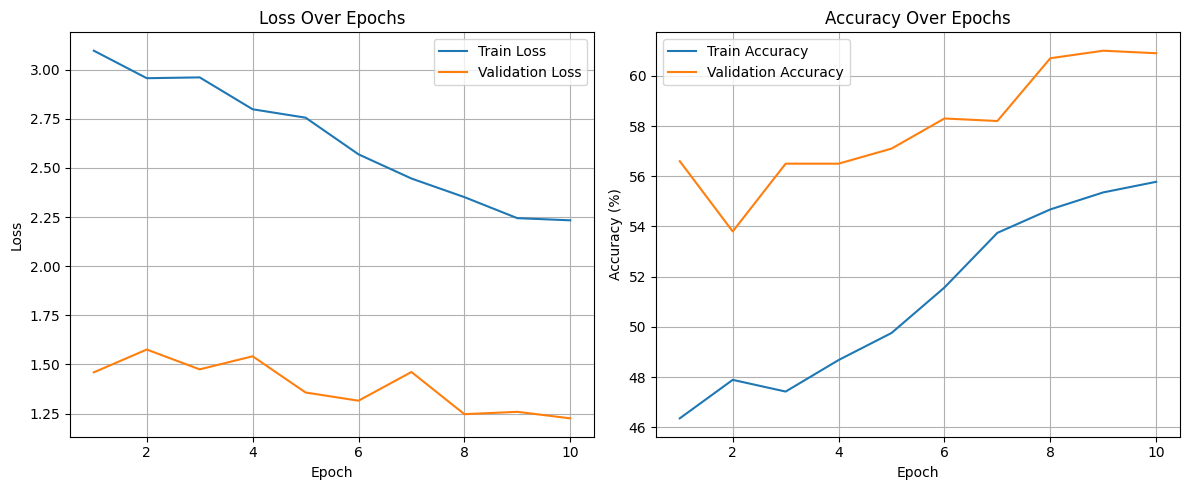

In [27]:
plot_training_history(history_resNet50)
plot_training_history(history_smallCNN)
plot_training_history(history_kd)

In [ ]:
model = get_resNet18()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model, history = train(model, train_loader, val_loader, device, epochs=30, lr=0.001)

In [ ]:
plot_training_history(history)